In [11]:
tree_path = "dist/augur/builds/flu/auspice/flu_h3n2_ha_2000-2012y_30v_3_tree.json"
frequencies_path = "frequencies/flu_h3n2_ha_2006-2018y_92v_3.json"
model_path = "models/2006-2018/92/ep/3.json"

In [12]:
from collections import defaultdict
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys

%matplotlib inline

In [13]:
os.getcwd()

'/Users/jlhudd/projects/nextstrain/flu-forecasting/analyses/projected-frequencies'

In [14]:
augur_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "dist", "augur")

In [15]:
sys.path.append(augur_path)

In [16]:
from base.fitness_model import fitness_model as FitnessModel
from base.frequencies import KdeFrequencies
from base.io_util import json_to_tree

In [17]:
def load_tree_from_json_filename(filename):
    # Load JSON tree.
    with open(filename, "r") as json_fh:
         json_tree = json.load(json_fh)

    # Convert JSON tree layout to a Biopython Clade instance.
    tree = json_to_tree(json_tree)

    return tree

def load_frequencies_from_json_filename(filename):
    # Load JSON frequencies.
    with open(filename, "r") as json_fh:
         json_frequencies = json.load(json_fh)

    # Create frequencies instance from JSON.
    frequencies = KdeFrequencies.from_json(json_frequencies)

    return frequencies

def project_clade_frequencies_by_delta_from_time(tree, model, time, delta, delta_steps_per_year=12):
    """
    Project clade frequencies from a given time to the future by a given delta.
    """
    # Calculate the steps between the projection date and delta time into the
    # future. First, find the frequency pivot that is closest to the requested
    # projection date.
    max_date = model.timepoints[np.searchsorted(model.timepoints, time)]
    future_date = max_date + delta

    # Then, calculate a fixed number of steps between that pivot and delta time
    # into the future.
    projected_pivots = np.linspace(max_date, future_date, int(delta_steps_per_year * delta))
    deltas = projected_pivots - max_date

    # Identify tip predictors and frequencies at the current time point.
    all_pred = model.predictor_arrays[max_date]
    all_freqs = model.freq_arrays[max_date]

    # For each requested delta, project current tip frequencies using the model
    # and calculate the corresponding projected clade frequencies.
    projected_clade_frequencies = defaultdict(list)

    for delta in deltas:
        # Project all tip frequencies.
        pred_freq = model.projection(model.model_params, all_pred, all_freqs, delta)

        # Normalize projected frequencies.
        pred_freq = pred_freq / pred_freq.sum()

        # Store projected frequencies by clade id.
        for i, tip in enumerate(model.tips):
            projected_clade_frequencies[tip.clade].append(pred_freq[i])

        # Calculate projected frequencies for internal nodes and store by clade it.
        for node in tree.find_clades(order="postorder"):
            if not node.is_terminal():
                projected_clade_frequencies[node.clade].append(pred_freq[node.tips].sum())

    projected_frequencies = {
        "params": {
            "max_date": max_date
        },
        "data": {
            "pivots": projected_pivots.tolist(),
            "frequencies": projected_clade_frequencies
        }
    }

    return projected_frequencies

In [18]:
tree = load_tree_from_json_filename(tree_path)

IOError: [Errno 2] No such file or directory: 'dist/augur/builds/flu/auspice/flu_h3n2_ha_2006-2018y_30v_3_tree.json'

In [ ]:
tree

In [9]:
frequencies = load_frequencies_from_json_filename(frequencies_path)

In [10]:
frequencies

In [11]:
with open(model_path, "r") as fh:
    json_model = json.load(fh)

predictors = {record["predictor"]: [round(record["param"], 2), round(record["global_sd"], 2)]
              for record in json_model["params"]}
predictors_key = "-".join(sorted([record["predictor"] for record in json_model["params"]]))
predictor_kwargs = json_model["predictor_kwargs"]

model = FitnessModel(
    tree,
    frequencies,
    predictors,
    epitope_masks_fname="%s/builds/flu/metadata/ha_masks.tsv" % augur_path,
    epitope_mask_version="wolf",
    tolerance_mask_version="HA1",
    min_freq=0.1,
    predictor_kwargs=predictor_kwargs
)
model.prep_nodes()
model.delta_time = json_model["delta_time"]

predictor_arrays = {}
for key in json_model["predictor_arrays"]:
    predictor_arrays[float(key)] = np.array(json_model["predictor_arrays"][key])

model.predictor_arrays = predictor_arrays

freq_arrays = {}
for key in json_model["freq_arrays"]:
    freq_arrays[float(key)] = np.array(json_model["freq_arrays"][key])

model.freq_arrays = freq_arrays

model.select_clades_for_fitting()

setup wolf epitope mask and HA1 tolerance mask


In [12]:
model.timepoints

array([ 2007.25,  2007.76,  2008.26,  2008.77,  2009.27,  2009.77,
        2010.28,  2010.78,  2011.29,  2011.79,  2012.29,  2012.8 ,
        2013.3 ,  2013.81,  2014.31,  2014.81,  2015.32,  2015.82,
        2016.33,  2016.83,  2017.33,  2018.33])

In [23]:
time = 2013.81
frequency_params = frequencies.get_params()
frequency_params["max_date"] = time
censored_frequencies = KdeFrequencies(**frequency_params)
censored = censored_frequencies.estimate(tree)

In [24]:
projected_frequencies = project_clade_frequencies_by_delta_from_time(tree, model, time, delta=1.0)

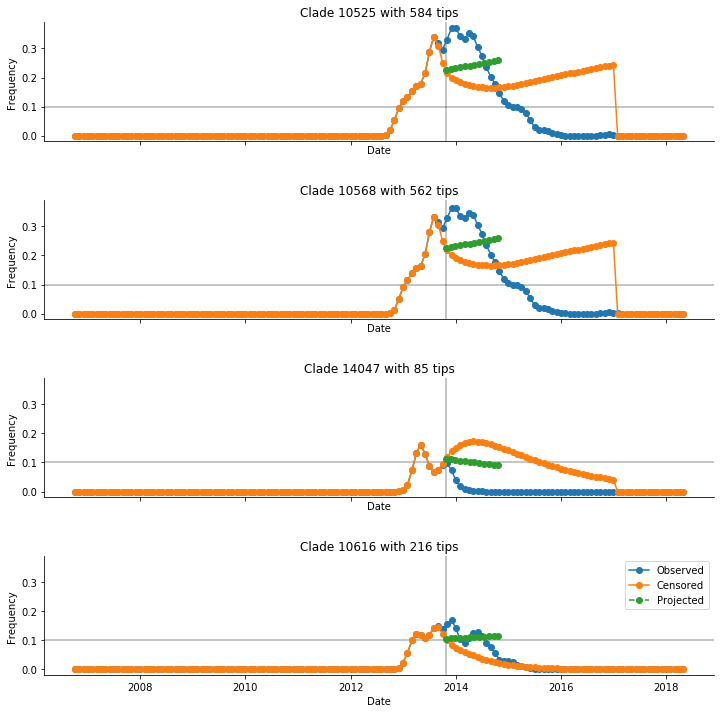

In [25]:
number_of_clades = 4
fig, axes = plt.subplots(number_of_clades, 1, figsize=(12, 3 * number_of_clades), sharex=True, sharey=True,
                         squeeze=False, gridspec_kw={"hspace": 0.5})
flat_axes = axes.flatten()
random_clades = np.random.choice(model.fit_clades[time], size=number_of_clades)

for i, clade in enumerate(random_clades):
    ax = flat_axes[i]
    ax.set_title("Clade %s with %s tips" % (clade.clade, len(clade.get_terminals())))
    ax.plot(model.pivots, frequencies.frequencies[clade.clade], "o-",
            label="Observed")
    ax.plot(model.pivots, censored_frequencies.frequencies[clade.clade], "o-",
            label="Censored")
    ax.plot(projected_frequencies["data"]["pivots"], projected_frequencies["data"]["frequencies"][clade.clade], "o--",
            label="Projected")

    ax.axhline(y=0.1, color="#000000", alpha=0.3, zorder=-10)
    ax.axvline(x=time, color="#000000", alpha=0.3, zorder=-10)

    #ax.set_xlim(2008, 2012)
    ax.set_xlabel("Date")
    ax.set_ylabel("Frequency")

ax.legend()
sns.despine()